## Lesson 2

Making a multi class classification model that identifies three types of bears.

In [22]:
from fastcore.all import *
from fastbook import *
from fastai.vision.widgets import *
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
ims = search_images_ddg('grizzly bear')
len(ims)

200

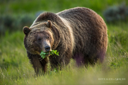

In [6]:
dest = 'images/grizzly.jpg'
download_url(ims[1], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(128,128)

In [4]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    results = search_images_ddg(f'{o} bear')
    download_images(dest, urls=results)

In [5]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

In [11]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(128, method='squish')]
)

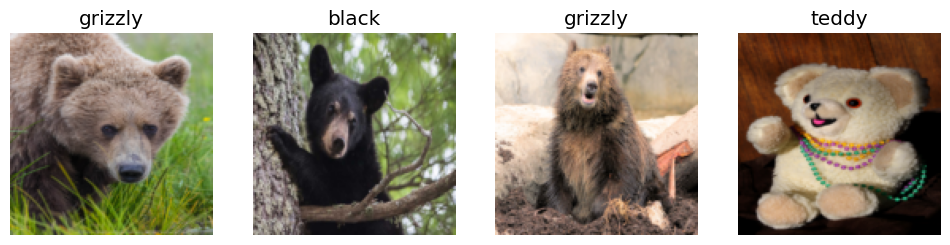

In [12]:
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

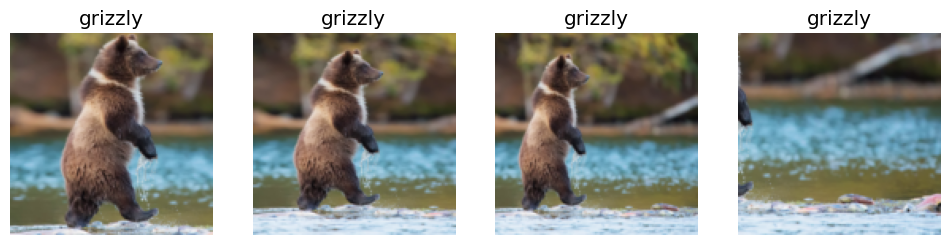

In [13]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

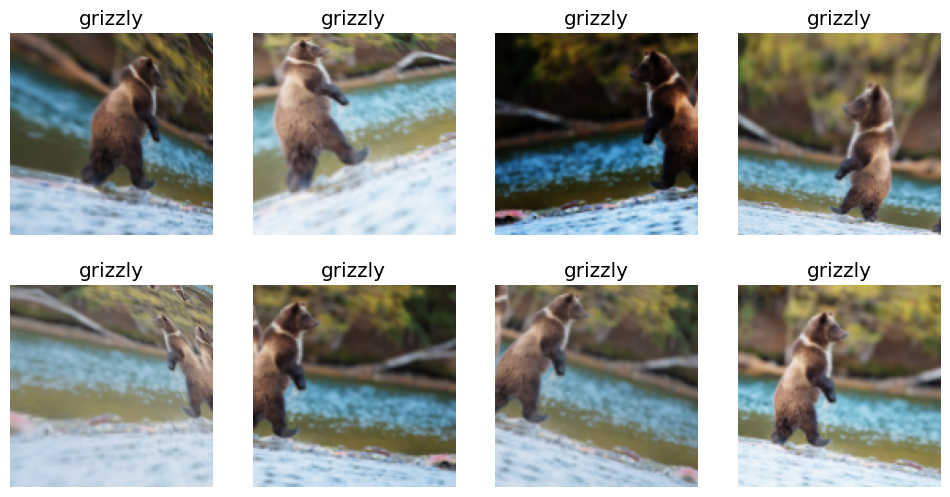

In [14]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [15]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [18]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.079530,0.108122,0.017857,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.097198,0.113051,0.026786,00:10
1,0.084657,0.090498,0.035714,00:10
2,0.066205,0.079794,0.035714,00:09
3,0.051071,0.081368,0.035714,00:09


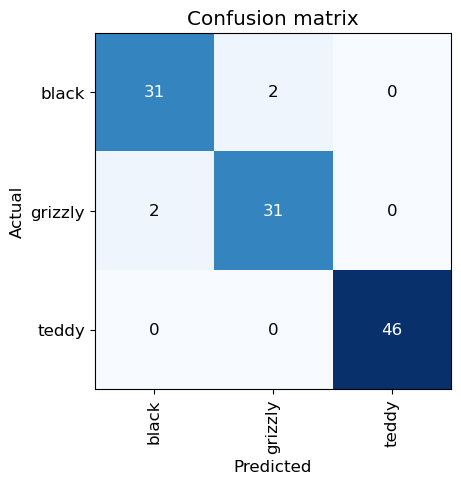

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

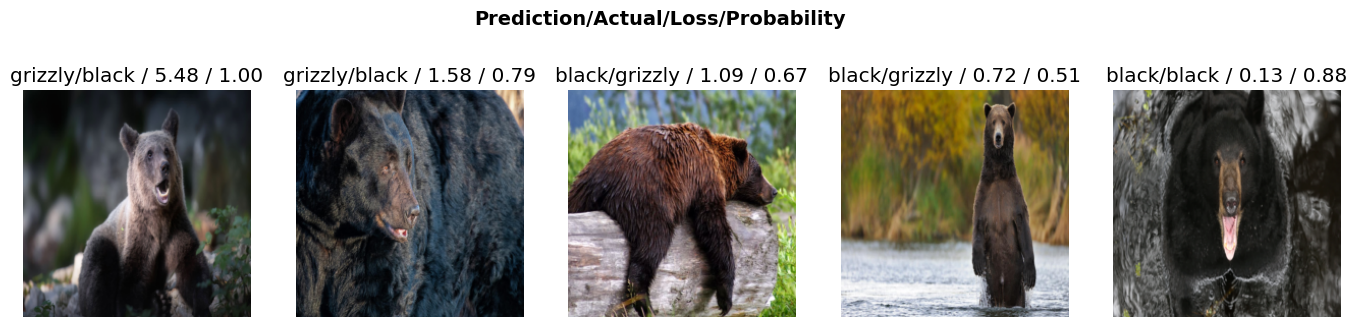

In [20]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

In [23]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [24]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)